### Prepare

In [1]:
import os
from pathlib import Path
import sqlite3

import pandas as pd
import vcfpy

In [2]:
dbfile = 'snps.sqlite'
db = sqlite3.connect(dbfile)
vcf = './vcf_files/snps.annotated.vcf'

In [3]:
print(f"dbfile      : {dbfile}")
print(f"db          : {db}")
print(f"vcf         : {vcf}")
print(f"vcf exist?  : {Path(vcf).exists()}")

dbfile      : snps.sqlite
db          : <sqlite3.Connection object at 0x1492b782d040>
vcf         : ./vcf_files/snps.annotated.vcf
vcf exist?  : True


### Check the contents of the vcf file:

In [4]:
#head of the vcf file
!grep -v '##' $vcf | grep '#' | head -1 | cut -f-7
!( grep -v '#' $vcf | head -5 | cut -f-7 ) 2>/dev/null

#CHROM	POS	ID	REF	ALT	QUAL	FILTER
chr9	127578816	.	C	T	36.1174	.
chr9	127578974	.	A	G	422.738	.
chr9	127579080	.	A	G	172.022	.
chr9	127663498	.	C	T	66.0472	.
chr9	127674824	.	G	T	24.6981	.


In [5]:
#INFO field of the vcf file
!( grep -v '#' $vcf | head -3 | cut -f8 ) 2>/dev/null

DP=13;VDB=0.764235;SGB=-2.83311;RPBZ=-0.677989;MQBZ=0;BQBZ=0.173623;SCBZ=1.82574;MQ0F=0;AC=2;AN=4;DP4=10,0,3,0;MQ=60;ANN=T|upstream_gene_variant|MODIFIER|STXBP1|ENSG00000136854|transcript|ENST00000637521.2|protein_coding||c.-724C>T|||||554|,T|intron_variant|MODIFIER|NIBAN2|ENSG00000136830|transcript|ENST00000373314.7|protein_coding|1/13|c.16+106G>A||||||
DP=111;VDB=0.0155294;SGB=-15.1563;RPBZ=0.0484509;MQBZ=0;MQSBZ=0;BQBZ=6.48514;SCBZ=0;MQ0F=0;AC=2;AN=4;DP4=21,47,16,27;MQ=60;ANN=G|5_prime_UTR_variant|MODIFIER|NIBAN2|ENSG00000136830|transcript|ENST00000373314.7|protein_coding|1/14|c.-37T>C|||||37|,G|upstream_gene_variant|MODIFIER|STXBP1|ENSG00000136854|transcript|ENST00000637521.2|protein_coding||c.-566A>G|||||396|
DP=19;VDB=0.0909238;SGB=-4.72235;RPBZ=0.245488;MQBZ=0;MQSBZ=0;BQBZ=1.02969;SCBZ=0;MQ0F=0;AC=2;AN=4;DP4=3,7,0,9;MQ=60;ANN=G|upstream_gene_variant|MODIFIER|NIBAN2|ENSG00000136830|transcript|ENST00000373314.7|protein_coding||c.-143T>C|||||91|,G|upstream_gene_variant|MODIFIER|STX

In [6]:
#FORMAT / genotype calls of the vcf file
!grep -v '##' $vcf | grep '#' | head -1 | cut -f9-
!( grep -v '#' $vcf | head -3 | cut -f9- ) 2>/dev/null

FORMAT	020.bwa/TLE66_N.bam	020.bwa/TLE66_T.bam
GT:PL	0/1:24,0,97	0/1:48,0,134
GT:PL	0/1:255,0,255	0/1:201,0,255
GT:PL	0/1:110,0,133	0/1:95,0,118


### Load the data

In [7]:
# Empty lists to store the data in
snp_records = []
effect_records = []
call_records = []

# These are the columns from a SNPeff record - easy to later assign column names
effect_rec_names = """snp allele effect impact gene gene_id feature_type feature_id 
                      biotype rank hgvs.c hgvs.p cdna_pos cds_pos prot_pos distance_to_feature
                      messages""".split()

# start parsing through the VCF:
j = 0

#open the vcf iterator:
reader = vcfpy.Reader.from_path(vcf)

for i, record in enumerate(reader):
    j += 1
    
    # we used vt decompose - so I expect NO multiallelic SNPs
    assert len(record.ALT) == 1 
    
    # this is the ALT allele (first and only)
    alt = record.ALT[0]
    
    # compose a SNP name for joins later on
    snp_name = f"{record.CHROM}:{record.POS}:{record.REF}:{alt.value}"
    
    # Store a SNP record - I collect everything now in a list of dictionaries
    # that I will later convert to a Pandas dataframe
    snp_records.append(
        dict(snp = snp_name,
             chrom = record.CHROM,
             pos = record.POS,
             quality = record.QUAL,
             ref = record.REF,
             type = alt.type,
             alt = alt.value))
    
    
    # Now I will parse through the individual calls
    for call_record in record.calls:
        
        #name of the sample (TLE66_N or TLE66_T)
        sample = os.path.basename(call_record.sample)
        sample = sample.replace('.bam', '')

        # simple genotype - -1 means not called, otherwise it's the number of ALT alleles observer
        # this helps in later queries 
        # Note - this is not perfect - it does ignore uncalled loci (./.)
        genotype_simple = call_record.data['GT'].count('1')
        
        call_records.append(
            dict(snp = snp_name,
                 sample = sample,
                 genotype = call_record.data['GT'], 
                 genotype_simple = genotype_simple))

    # and parse through all snpEff annotations
    for ann in record.INFO['ANN']:
        ann = ann.split('|')
        # create a dictionary of all fields
        eff_record = dict(zip(effect_rec_names, [snp_name] + ann))
        #from pprint import pprint
        #pprint(eff_record)
        # convert distance to feature to integer
        try:
            eff_record['distance_to_feature'] = int(eff_record.get(intfield))
        except:
            eff_record['distance_to_feature'] = -1
            
        effect_records.append(eff_record)

print(len(snp_records))
print(len(call_records))
print(len(effect_records))

3499
6998
19601


In [8]:
#convert lists of dicts to a DataFrame
snp_records = pd.DataFrame.from_records(snp_records)
call_records = pd.DataFrame.from_records(call_records)
effect_records = pd.DataFrame.from_records(effect_records)

#Save to the database
print('snp records        :', snp_records.to_sql('snp', db, if_exists='replace', index=False))
print('snp_call records   :', call_records.to_sql('snp_call', db, if_exists='replace', index=False))
print('snp_effect records :', effect_records.to_sql('snp_effect', db, if_exists='replace', index=False))

snp records        : 3499
snp_call records   : 6998
snp_effect records : 19601


In [9]:
snp_records.head()

,snp,chrom,pos,quality,ref,type,alt
0,chr9:127578816:C:T,chr9,127578816,36.1174,C,SNV,T
1,chr9:127578974:A:G,chr9,127578974,422.7380,A,SNV,G
2,chr9:127579080:A:G,chr9,127579080,172.0220,A,SNV,G
3,chr9:127663498:C:T,chr9,127663498,66.0472,C,SNV,T
4,chr9:127674824:G:T,chr9,127674824,24.6981,G,SNV,T


<Axes: xlabel='genotype'>

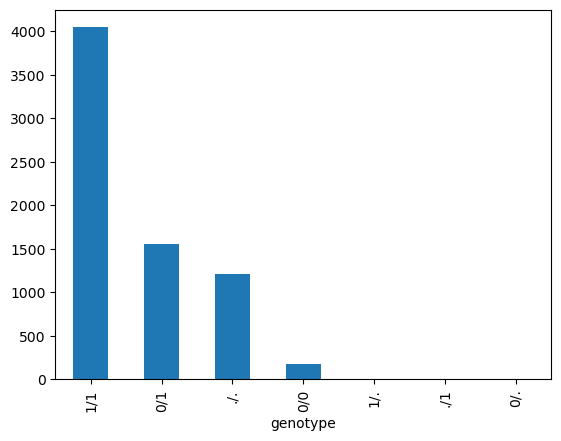

In [10]:
call_records['genotype'].value_counts().plot.bar()

In [11]:
effect_records.head(3).T

,0,1,2
snp,chr9:127578816:C:T,chr9:127578816:C:T,chr9:127578974:A:G
allele,T,T,G
effect,upstream_gene_variant,intron_variant,5_prime_UTR_variant
impact,MODIFIER,MODIFIER,MODIFIER
gene,STXBP1,NIBAN2,NIBAN2
gene_id,ENSG00000136854,ENSG00000136830,ENSG00000136830
feature_type,transcript,transcript,transcript
feature_id,ENST00000637521.2,ENST00000373314.7,ENST00000373314.7
biotype,protein_coding,protein_coding,protein_coding
rank,,1/13,1/14


### Some test queries

In [12]:
pd.read_sql('SELECT * FROM snp  WHERE type != "SNV" LIMIT 5', db)

,snp,chrom,pos,quality,ref,type,alt
0,chr9:127736258:TCA:T,chr9,127736258,33.9279,TCA,DEL,T
1,chr9:127786310:G:GC,chr9,127786310,143.9790,G,INS,GC
2,chr9:127824773:A:AGGGAGG,chr9,127824773,79.6809,A,INS,AGGGAGG
3,chr9:127870805:CGGGGCATGGGAAT:C,chr9,127870805,57.0471,CGGGGCATGGGAAT,DEL,C
4,chr9:127894741:GC:G,chr9,127894741,336.8370,GC,DEL,G


In [13]:
pd.read_sql("SELECT * FROM snp_call LIMIT 5", db)

,snp,sample,genotype,genotype_simple
0,chr9:127578816:C:T,TLE66_N,0/1,1
1,chr9:127578816:C:T,TLE66_T,0/1,1
2,chr9:127578974:A:G,TLE66_N,0/1,1
3,chr9:127578974:A:G,TLE66_T,0/1,1
4,chr9:127579080:A:G,TLE66_N,0/1,1


In [14]:
# .T transposes - easier viewing
pd.read_sql("SELECT * FROM snp_effect LIMIT 5", db)

,snp,allele,effect,impact,gene,gene_id,feature_type,feature_id,biotype,rank,hgvs.c,hgvs.p,cdna_pos,cds_pos,prot_pos,distance_to_feature,messages
0,chr9:127578816:C:T,T,upstream_gene_variant,MODIFIER,STXBP1,ENSG00000136854,transcript,ENST00000637521.2,protein_coding,,c.-724C>T,,,,,-1,
1,chr9:127578816:C:T,T,intron_variant,MODIFIER,NIBAN2,ENSG00000136830,transcript,ENST00000373314.7,protein_coding,1/13,c.16+106G>A,,,,,-1,
2,chr9:127578974:A:G,G,5_prime_UTR_variant,MODIFIER,NIBAN2,ENSG00000136830,transcript,ENST00000373314.7,protein_coding,1/14,c.-37T>C,,,,,-1,
3,chr9:127578974:A:G,G,upstream_gene_variant,MODIFIER,STXBP1,ENSG00000136854,transcript,ENST00000637521.2,protein_coding,,c.-566A>G,,,,,-1,
4,chr9:127579080:A:G,G,upstream_gene_variant,MODIFIER,NIBAN2,ENSG00000136830,transcript,ENST00000373314.7,protein_coding,,c.-143T>C,,,,,-1,
